*One layer BiLSTM Ablation*

We reduce 2 layers of BiLSTM to just 1 to see the impact of depth of BiLSTM layers on performance.

--Yash Priyadarshi and Darshan Chudiwal

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from gensim.models import KeyedVectors

In [2]:
TRAIN_PATH = '/kaggle/input/bias-of-us-news-media-houses/Train.xlsx'

def clean_text(text: str) -> str:
    """Clean the input text by removing URLs, 'RT', special characters, and extra whitespace."""
    text = re.sub(r"http\S+", " ", text)  # remove URLs
    text = re.sub(r"RT ", " ", text)       # remove 'RT'
    text = re.sub(r"[^a-zA-Z\'\.\,\d\s]", " ", text)  # remove unwanted characters
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def load_and_preprocess_data(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, engine='openpyxl')
    for col in ['content_original', 'title']:
        # Use only the first section if split by the delimiter
        df[col] = df[col].str.split(' \n\n---\n\n').str[0]
        # Replace dashes and punctuation, then lower the text
        df[col] = (df[col]
                   .str.replace('-', ' ')
                   .str.replace('[^\w\s]', '', regex=True)
                   .str.replace('\n', ' ')
                   .str.lower())
        df[col] = df[col].apply(clean_text)
    return df

# Load and preview the data
df_train = load_and_preprocess_data(TRAIN_PATH)
df_train.head(2)


,Unnamed: 0,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,0,immigration,National Review,2,https://www.nationalreview.com/2018/12/governm...,shutdown theater again,2018-12-12,"Kevin D. Williamson, Kyle Smith, Andrew C. Mcc...",President Trump and Senate Minority Leader Chu...,president trump and senate minority leader chu...,www.nationalreview.com,right,zl7kc7EmAyIdUMIo
1,1,culture,Yahoo! The 360,1,https://news.yahoo.com/can-the-developing-worl...,can the developing world endure the coronavirus,2020-06-30,Mike Bebernes,“ The 360 ” shows you diverse perspectives on ...,the 360 shows you diverse perspectives on the ...,www.news.yahoo.com,center,xpbjYTJYPdlw6HmJ


In [3]:
# Update the path to your Word2Vec file; for example:
word2vec_model_path = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
cached_kv_path = 'word2vec_model.kv'

if os.path.exists(cached_kv_path):
    print("Loading cached Word2Vec model...")
    w2v_model = KeyedVectors.load(cached_kv_path, mmap='r')
else:
    print("Loading Word2Vec model from binary file (this may take several minutes)...")
    w2v_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)
    print("Saving cached version...")
    w2v_model.save(cached_kv_path)

# Build vocabulary mapping and embedding matrix.
# Reserve index 0 for unknown words.
UNK_TOKEN = "<unk>"
UNK_INDEX = 0
# Create vocabulary mapping, shifting indices by 1 so that index 0 is reserved for UNK.
word2vec_vocab = {word: idx + 1 for word, idx in w2v_model.key_to_index.items()}
vocab_size = len(word2vec_vocab) + 1
embedding_dim = w2v_model.vector_size  # typically 300

# Build the embedding matrix (row 0 will remain zeros for UNK)
embedding_matrix = torch.zeros(vocab_size, embedding_dim)
for word, idx in word2vec_vocab.items():
    embedding_matrix[idx] = torch.tensor(w2v_model[word])
    
print(f"Word2Vec embeddings loaded: vocab size = {vocab_size}, embedding dim = {embedding_dim}")


Loading Word2Vec model from binary file (this may take several minutes)...
Saving cached version...
Word2Vec embeddings loaded: vocab size = 3000001, embedding dim = 300


In [4]:
def basic_tokenizer(text: str) -> list:
    """Tokenize text by splitting on whitespace."""
    return text.split()

def tokenize_and_pad(text: str, max_len: int) -> torch.Tensor:
    """
    Tokenizes the input text and converts tokens to indices using the Word2Vec vocabulary.
    Unknown tokens are assigned index 0. The sequence is padded or truncated to max_len.
    """
    tokens = basic_tokenizer(text)
    indices = [word2vec_vocab.get(token, UNK_INDEX) for token in tokens]
    padded = indices[:max_len] + [0] * max(0, max_len - len(indices))
    return torch.tensor(padded)


In [5]:
class BiasDataset(Dataset):
    def __init__(self, data: pd.DataFrame, max_sentence_length: int):
        self.data = data.reset_index(drop=True)
        self.max_sentence_length = max_sentence_length

    def __len__(self) -> int:
        return len(self.data)
  
    def __getitem__(self, index: int) -> dict:
        row = self.data.iloc[index]
        body = tokenize_and_pad(row['content_original'], self.max_sentence_length)
        title = tokenize_and_pad(row['title'], self.max_sentence_length)
        # Assuming 'bias' is an integer label
        label = torch.tensor(row['bias'], dtype=torch.long)
        return {"body": body, "title": title, "labels": label}

class BiasDataModule(pl.LightningDataModule):
    def __init__(self, train_df: pd.DataFrame, val_df: pd.DataFrame, max_sentence_length: int, batch_size: int):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.max_sentence_length = max_sentence_length
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = BiasDataset(self.train_df, self.max_sentence_length)
        self.val_dataset = BiasDataset(self.val_df, self.max_sentence_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=4, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=4, drop_last=False)

# Split the dataset (e.g., 80% train, 20% validation)
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)
print("Train shape:", train_df.shape, "Val shape:", val_df.shape)

BATCH_SIZE = 1024
MAX_LEN = 120  # Adjust based on your text lengths
data_module = BiasDataModule(train_df, val_df, max_sentence_length=MAX_LEN, batch_size=BATCH_SIZE)
data_module.setup()


Train shape: (21272, 13) Val shape: (5318, 13)


In [6]:
class LitBiasModel_NoMHA(pl.LightningModule):
    def __init__(self, embedding_matrix: torch.Tensor, num_classes: int,
                 embed_dim: int, hidd_dim: int, num_layers: int = 2, lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters(ignore=["embedding_matrix"])
        # Frozen embedding layer using pretrained Word2Vec embeddings
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        
        # Shared bidirectional LSTM layer
        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidd_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.4,
            bidirectional=True
        )
        
        
        # Classification head (feedforward network)
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(hidd_dim, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.val_acc = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self._train_losses = []
        self._val_losses = []
        # Dictionaries to store history for later plotting:
        self.train_history = {"acc": [], "loss": []}
        self.val_history = {"acc": [], "loss": []}

    def forward(self, title: torch.Tensor, body: torch.Tensor) -> torch.Tensor:
        # Obtain embeddings
        title_embed = self.embedding(title)   # (batch, seq_len, embed_dim)
        body_embed = self.embedding(body)
        
        # Shared bidirectional LSTM for title and body separately:
        _, (title_hidden, _) = self.bilstm(title_embed)  # title_hidden: (num_layers*2, batch, hidd_dim)
        _, (body_hidden, _) = self.bilstm(body_embed)      # body_hidden: (num_layers*2, batch, hidd_dim)
        
        # Aggregate hidden states by mean pooling over the layers dimension:
        # Permute to (batch, num_layers*2, hidd_dim)
        title_hidden = title_hidden.permute(1, 0, 2)
        body_hidden = body_hidden.permute(1, 0, 2)
        
        # Mean pooling over the layer dimension
        title_repr = title_hidden.mean(dim=1)  # (batch, hidd_dim)
        body_repr = body_hidden.mean(dim=1)    # (batch, hidd_dim)
        
        # Fuse the representations (here we simply average them)
        aggregated = (title_repr + body_repr) / 2  # (batch, hidd_dim)
        
        logits = self.classifier(aggregated)
        return logits

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch["title"], batch["body"])
        loss = self.loss_fn(logits, batch["labels"])
        self._train_losses.append(loss)
        self.train_acc.update(logits, batch["labels"])
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self.forward(batch["title"], batch["body"])
        loss = self.loss_fn(logits, batch["labels"])
        self._val_losses.append(loss)
        self.val_acc.update(logits, batch["labels"])
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self._train_losses).mean() if self._train_losses else torch.tensor(0.0, device=self.device)
        train_acc = self.train_acc.compute()
        self.train_history["loss"].append(avg_loss.item())
        self.train_history["acc"].append(train_acc.item())
        self.log_dict({"Epoch_Train_Loss": avg_loss, "Epoch_Train_Acc": train_acc}, prog_bar=True)
        print(f"Train - Acc: {train_acc:.4f}, Loss: {avg_loss:.4f}")
        self.train_acc.reset()
        self._train_losses.clear()

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self._val_losses).mean() if self._val_losses else torch.tensor(0.0, device=self.device)
        val_acc = self.val_acc.compute()
        self.val_history["loss"].append(avg_loss.item())
        self.val_history["acc"].append(val_acc.item())
        self.log_dict({"Epoch_Val_Loss": avg_loss, "Epoch_Val_Acc": val_acc}, prog_bar=True)
        print(f"Val - Acc: {val_acc:.4f}, Loss: {avg_loss:.4f}")
        self.val_acc.reset()
        self._val_losses.clear()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

# Instantiate the ablated model: 1 layer of lstm
model = LitBiasModel_NoMHA(
    embedding_matrix=embedding_matrix,
    num_classes=3,
    embed_dim=300,
    hidd_dim=200,
    num_layers=1,
    lr=1e-3
)
print(model)


LitBiasModel_NoMHA(
  (embedding): Embedding(3000001, 300)
  (bilstm): LSTM(300, 200, batch_first=True, dropout=0.4, bidirectional=True)
  (classifier): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=64, bias=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.4, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.4, inplace=False)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=3, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


In [7]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

pl.seed_everything(42)
logger = TensorBoardLogger("tb_logs", name="lit_bias_model")
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=20,
    logger=logger,
    log_every_n_steps=10
)
trainer.fit(model, data_module)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3867, Loss: 1.0922


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.3800, Loss: 1.0928
Train - Acc: 0.3783, Loss: 1.1203


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.4171, Loss: 1.0754
Train - Acc: 0.4625, Loss: 1.0339


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.4983, Loss: 0.9966
Train - Acc: 0.5187, Loss: 0.9728


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6203, Loss: 0.8259
Train - Acc: 0.6036, Loss: 0.8773


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6373, Loss: 0.7916
Train - Acc: 0.6425, Loss: 0.8238


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6564, Loss: 0.7754
Train - Acc: 0.6769, Loss: 0.7653


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6790, Loss: 0.7251
Train - Acc: 0.6949, Loss: 0.7328


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6875, Loss: 0.7565
Train - Acc: 0.7213, Loss: 0.6868


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6862, Loss: 0.7036
Train - Acc: 0.7231, Loss: 0.6732


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7089, Loss: 0.6889
Train - Acc: 0.7413, Loss: 0.6406


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.6583, Loss: 0.8151
Train - Acc: 0.7172, Loss: 0.6997


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7070, Loss: 0.6850
Train - Acc: 0.7327, Loss: 0.6591


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7153, Loss: 0.6649
Train - Acc: 0.7599, Loss: 0.6075


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7127, Loss: 0.6602
Train - Acc: 0.7754, Loss: 0.5811


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7052, Loss: 0.6889
Train - Acc: 0.7845, Loss: 0.5609


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7339, Loss: 0.6357
Train - Acc: 0.7965, Loss: 0.5351


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7335, Loss: 0.6575
Train - Acc: 0.8129, Loss: 0.5026


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7292, Loss: 0.6498
Train - Acc: 0.8152, Loss: 0.4906


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7223, Loss: 0.6674
Train - Acc: 0.8281, Loss: 0.4639


Validation: |          | 0/? [00:00<?, ?it/s]

Val - Acc: 0.7251, Loss: 0.7142
Train - Acc: 0.8393, Loss: 0.4438


<Figure size 600x500 with 0 Axes>

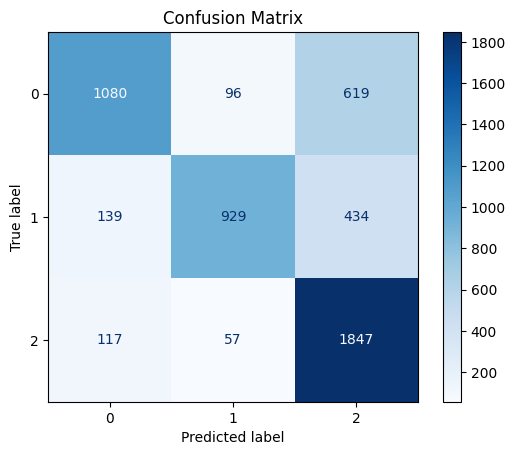

Classification Report:

              precision    recall  f1-score   support

           0     0.8084    0.6017    0.6899      1795
           1     0.8586    0.6185    0.7190      1502
           2     0.6369    0.9139    0.7507      2021

    accuracy                         0.7251      5318
   macro avg     0.7680    0.7114    0.7199      5318
weighted avg     0.7574    0.7251    0.7212      5318



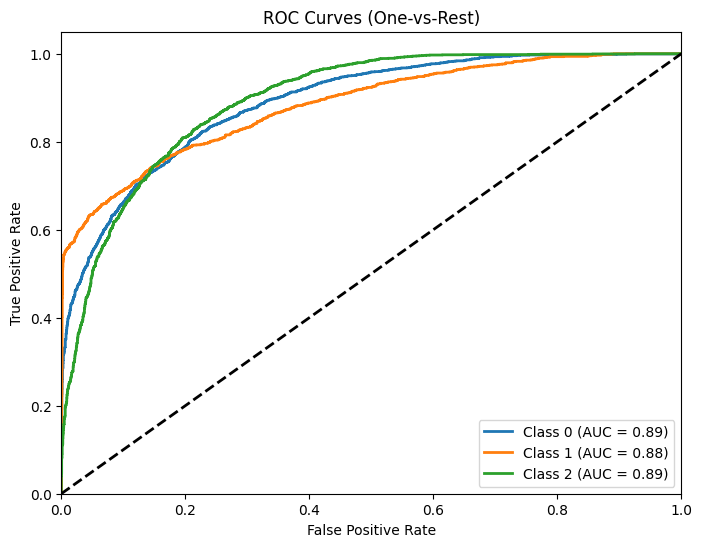

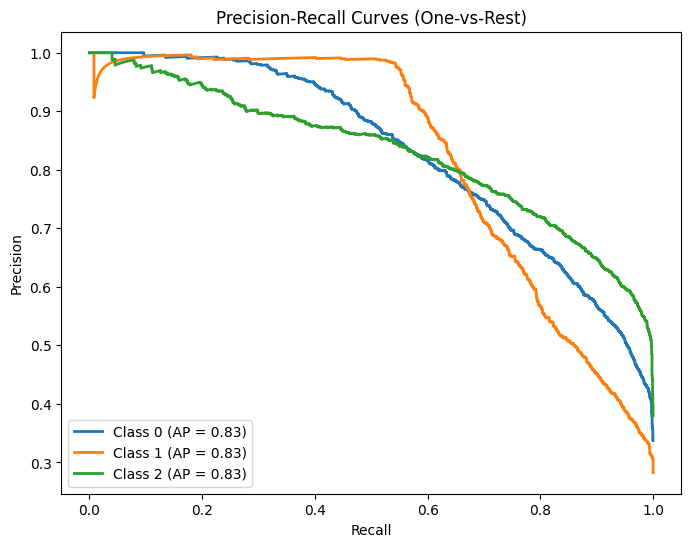

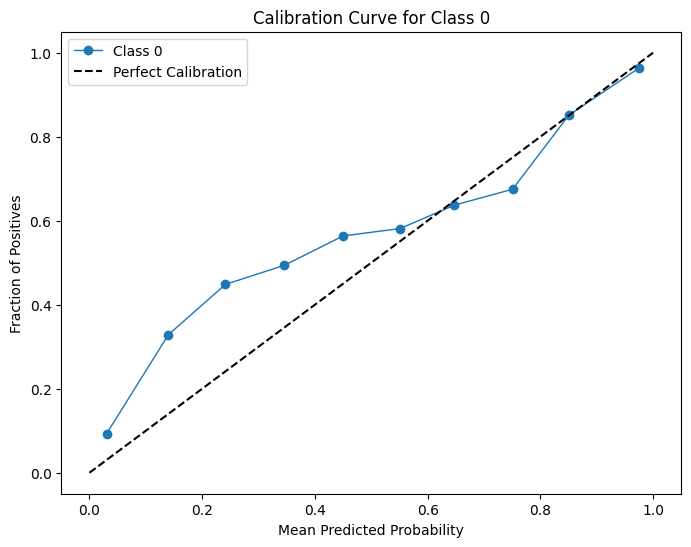

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
from sklearn.metrics import ConfusionMatrixDisplay

# -----------------------------------------------
# Step 1: Compute predictions on the validation set
# -----------------------------------------------

model.eval()
all_preds_list = []
all_labels_list = []
with torch.no_grad():
    for batch in data_module.val_dataloader():
        # Move data to the same device as your model
        title = batch["title"].to(model.device)
        body = batch["body"].to(model.device)
        labels = batch["labels"]
        logits = model(title, body)
        all_preds_list.append(logits.cpu())
        all_labels_list.append(labels.cpu())
        
# Concatenate batches into a single tensor
all_preds = torch.cat(all_preds_list)
all_labels = torch.cat(all_labels_list)

# Convert tensors to numpy arrays for use with scikit-learn
all_logits = all_preds.numpy()
all_labels_np = all_labels.numpy()

# -----------------------------------------------
# Step 2: Convert logits to probabilities using softmax
# -----------------------------------------------
def softmax(logits, axis=1):
    exp_logits = np.exp(logits - np.max(logits, axis=axis, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=axis, keepdims=True)

all_probs = softmax(all_logits, axis=1)
n_classes = all_probs.shape[1]

# -----------------------------------------------
# Step 3: Confusion Matrix & Classification Report
# -----------------------------------------------
predicted_classes = np.argmax(all_probs, axis=1)
cm = confusion_matrix(all_labels_np, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(all_labels_np, predicted_classes, digits=4))

# -----------------------------------------------
# Step 4: ROC Curves and AUC (One-vs-Rest)
# -----------------------------------------------
# Binarize labels for ROC computation
all_labels_bin = label_binarize(all_labels_np, classes=range(n_classes))
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

# -----------------------------------------------
# Step 5: Precision-Recall Curves
# -----------------------------------------------
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])
    avg_precision = average_precision_score(all_labels_bin[:, i], all_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i} (AP = {avg_precision:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (One-vs-Rest)")
plt.legend(loc="lower left")
plt.show()

# -----------------------------------------------
# Step 6: Calibration Curve (for one chosen class, e.g., Class 0)
# -----------------------------------------------
# calibration_curve returns two arrays: fraction of positives and mean predicted probability per bin.
prob_true, prob_pred = calibration_curve(all_labels_bin[:, 0], all_probs[:, 0], n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label="Class 0")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve for Class 0")
plt.legend()
plt.show()


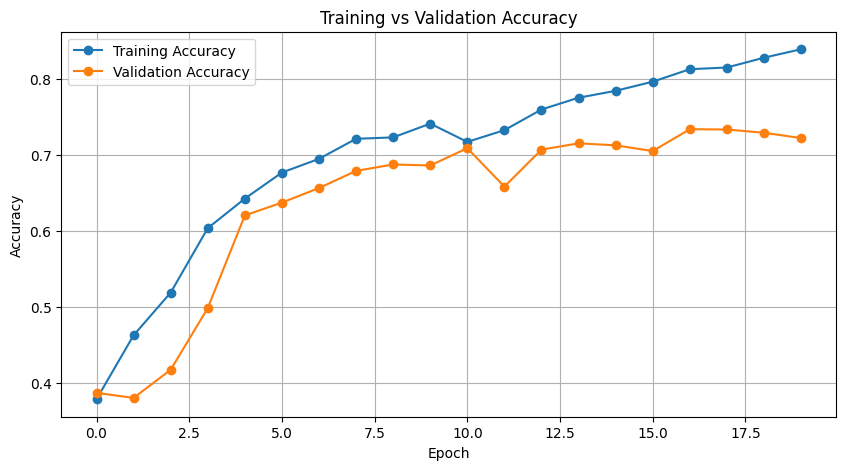

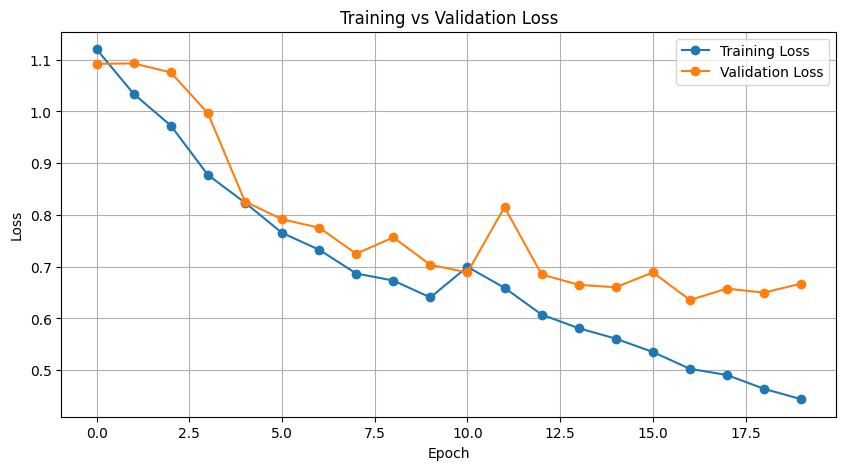

In [9]:
import matplotlib.pyplot as plt


# Plot Accuracy
min_length = min(len(model.train_history["acc"]), len(model.val_history["acc"]))
epochs = list(range(min_length))
train_acc = model.train_history["acc"][:min_length]  # Trim to min length
val_acc = model.val_history["acc"][:min_length]  # Trim to min length

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
train_loss = model.train_history["loss"][:min_length]
val_loss = model.val_history["loss"][:min_length]
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
